In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split, ParameterGrid
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error, mean_absolute_error, mean_squared_error
import warnings
import time
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../data/regional_univariate_data.csv')
enc = pd.read_csv('../data/regional_datasets/univariate/enc_data_univ.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/univariate/esc_data_univ.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/univariate/mid_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/univariate/mountain_data_univ.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/univariate/new_england_data_univ.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/univariate/pacific_data_univ.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/univariate/south_atlantic_data_univ.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/univariate/wnc_data_univ.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/univariate/wsc_data_univ.csv').drop(columns = 'Unnamed: 0')

In [4]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def smape(actual,forecast): 
    actual, forecast = np.array(actual), np.array(forecast)
    return 100/len(actual) * np.sum(2 * np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast)))

East North Central
112.37169098854065
MASE:  0.8437750720885758
Train MASE:  0.484593735509731
RMSE:  7904.308977991936
MAE:  6879.669617741159
Best Parameters:  {'d': 0, 'p': 9, 'q': 5}
East South Central
110.56091332435608
MASE:  1.7651996138054795
Train MASE:  0.8304230847407896
RMSE:  7850.640861481043
MAE:  5751.160340368313
Best Parameters:  {'d': 2, 'p': 3, 'q': 3}
Mid-Atlantic
115.6407732963562
MASE:  2.305328345243603
Train MASE:  1.0052543755868097
RMSE:  6392.818379502526
MAE:  5452.4115634165155
Best Parameters:  {'d': 0, 'p': 2, 'q': 5}
Mountain
115.29817724227905
MASE:  2.949821863105128
Train MASE:  0.6688681625673297
RMSE:  10368.406350716114
MAE:  9422.093824940943
Best Parameters:  {'d': 1, 'p': 7, 'q': 6}
New England
117.06653714179993
MASE:  1.0570821454542423
Train MASE:  0.7064410930073444
RMSE:  3365.539241249258
MAE:  2780.492983703194
Best Parameters:  {'d': 0, 'p': 9, 'q': 6}
Pacific
114.94270896911621
MASE:  1.7069136643169045
Train MASE:  0.6393233706432958


<Figure size 1500x500 with 0 Axes>

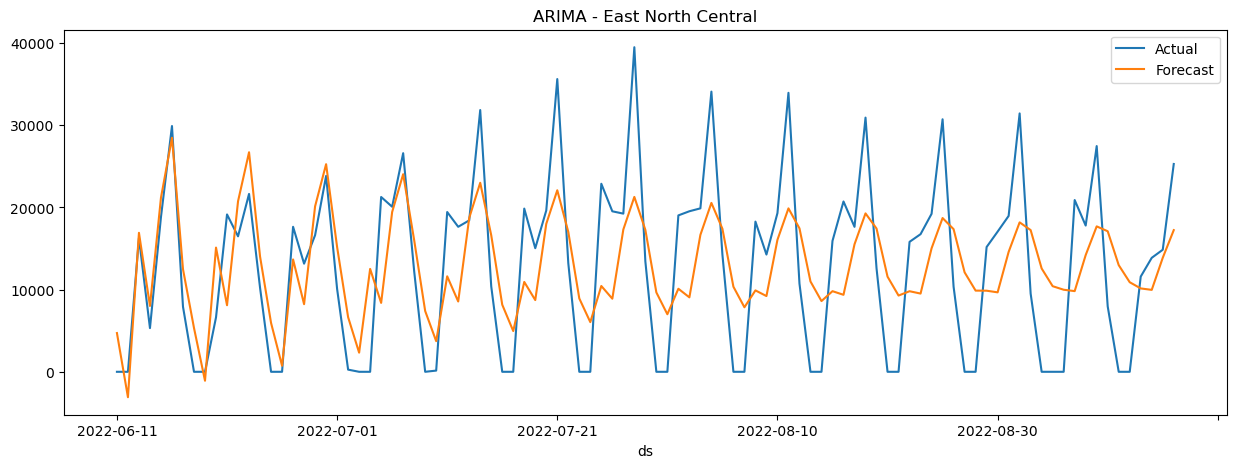

<Figure size 1500x500 with 0 Axes>

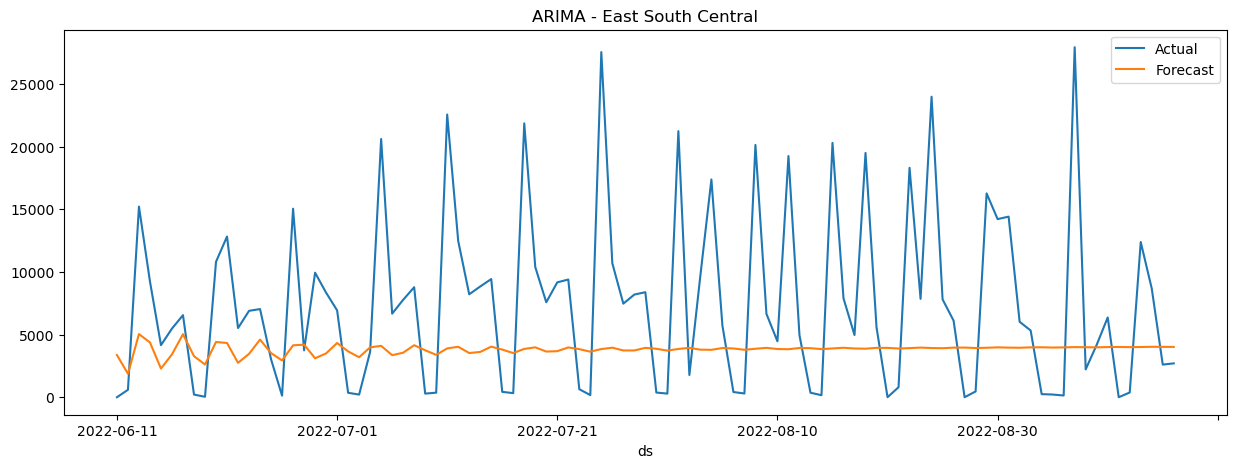

<Figure size 1500x500 with 0 Axes>

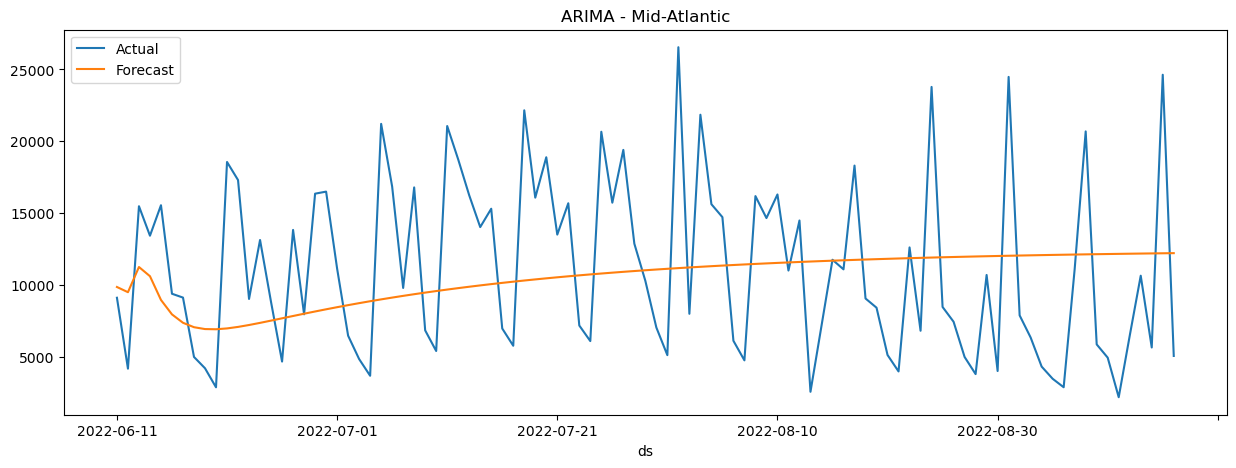

<Figure size 1500x500 with 0 Axes>

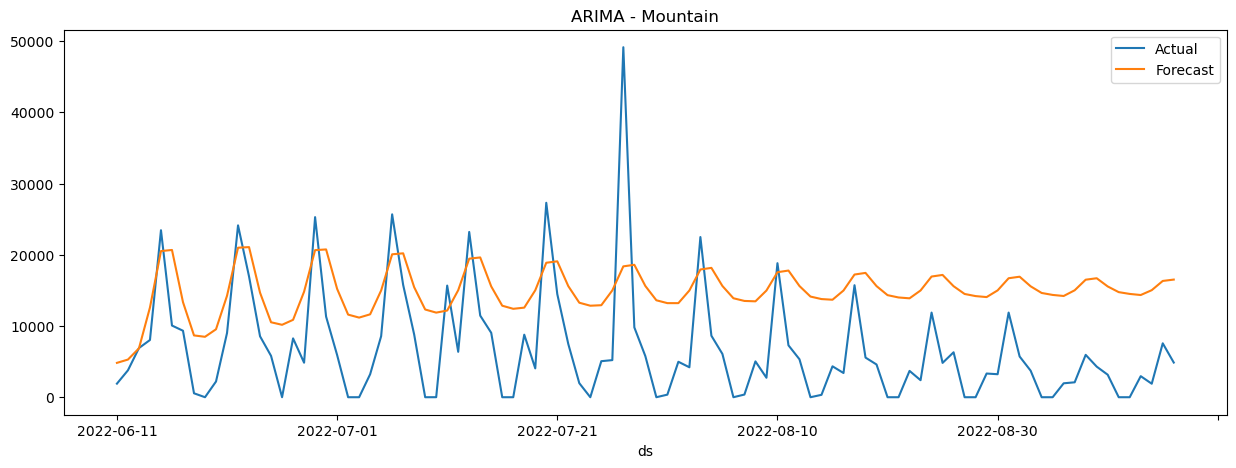

<Figure size 1500x500 with 0 Axes>

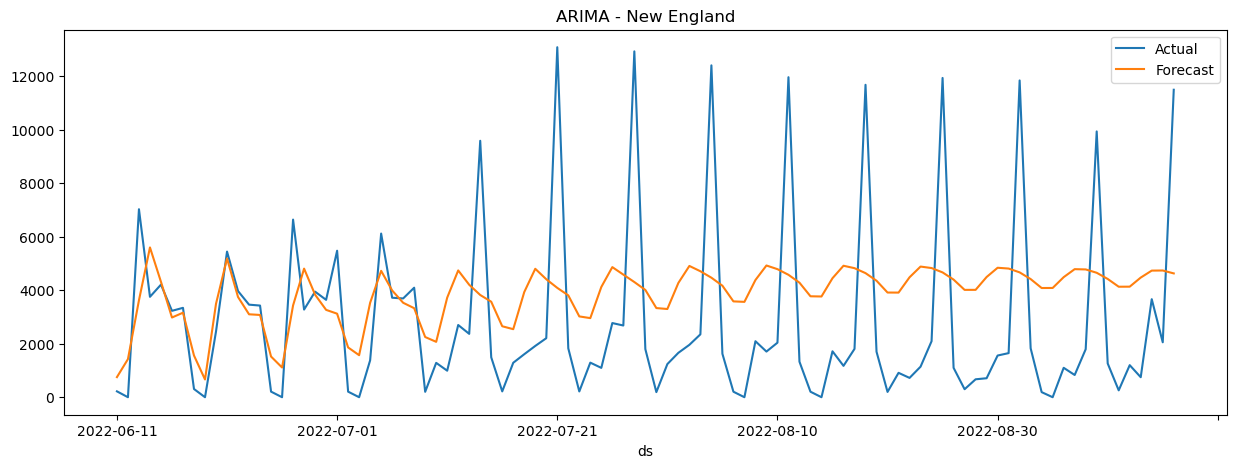

<Figure size 1500x500 with 0 Axes>

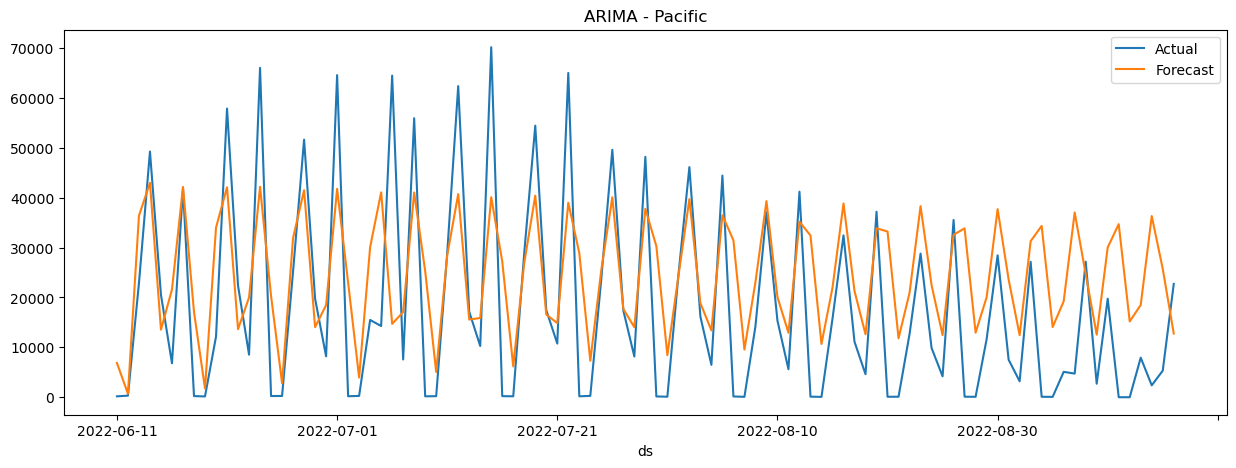

<Figure size 1500x500 with 0 Axes>

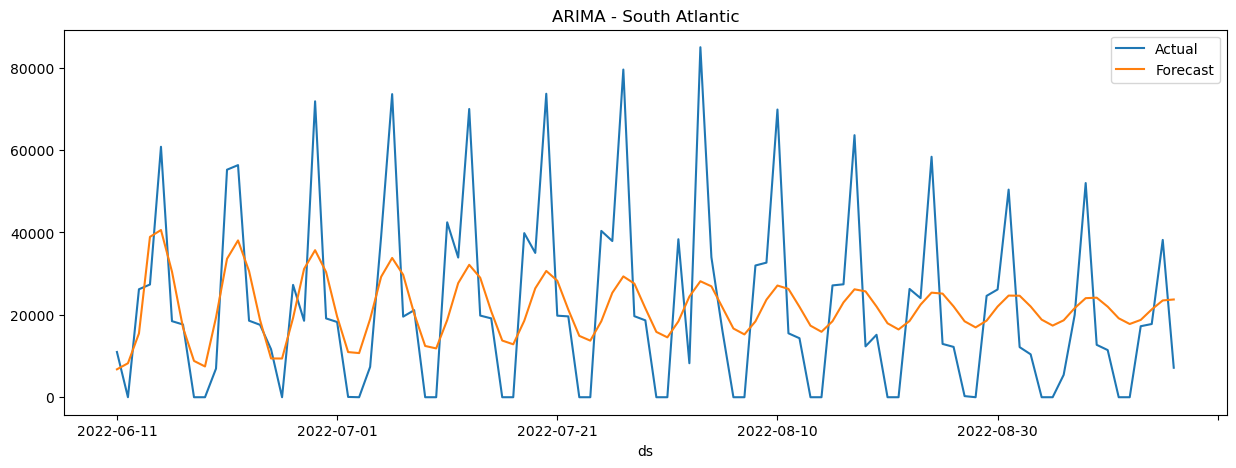

<Figure size 1500x500 with 0 Axes>

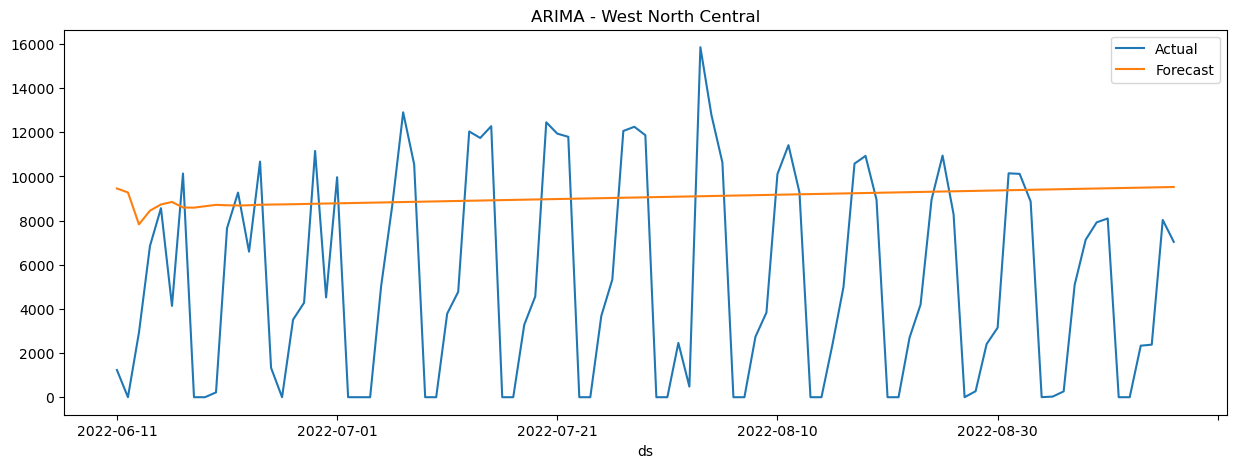

<Figure size 1500x500 with 0 Axes>

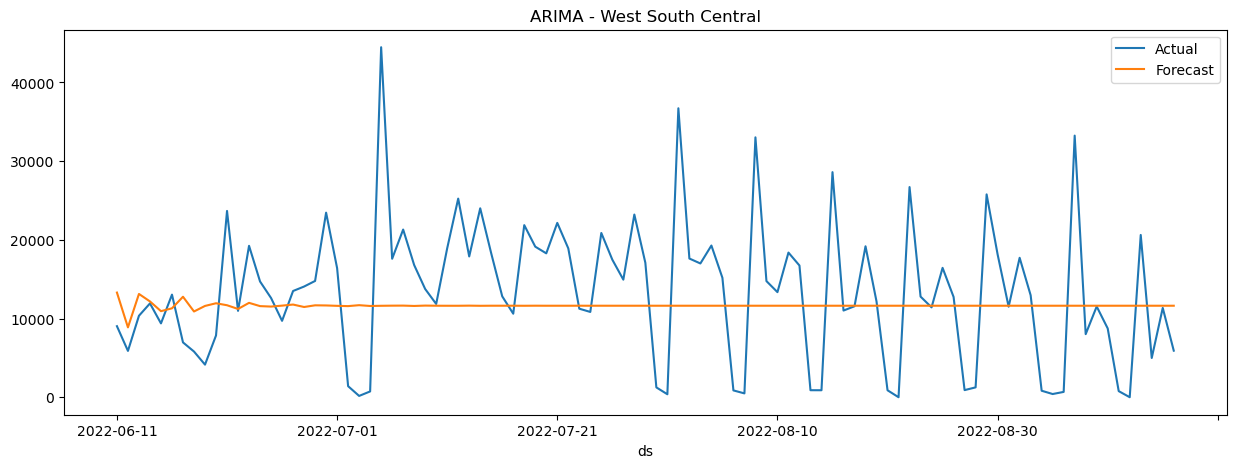

In [20]:
params_grid = {'p': [1,2,3,4,5,6,7,8,9,10],
               'd': [0,1,2],
               'q': [1,2,3,4,5,6,7]}
grid = ParameterGrid(params_grid)
best_params = []
best_params2 = []
best_smape = []
best_mase = []
for data1 in [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]:
# for data1 in [midatl]:
    start = time.time()
    print(data1.region.unique()[0])
    data = data1[['date', 'new_confirmed']].rename(columns = {'date': 'ds', 'new_confirmed': 'y'})
    size = round(data.shape[0]*0.1)
    train = data.iloc[:-size*2]
    val = data.iloc[-size*2:-size]
    trainval = data.iloc[:-size]
    test = data.iloc[-size:].reset_index().drop(columns = 'index')
    params = []
    smapes = []
    mases = []
    for param in grid:
        params.append(param)
        model = ARIMA(train.y, order = (param['p'], param['d'], param['q']))
        model.initialize_approximate_diffuse()
        model = model.fit()
        train_pred = model.fittedvalues
        val_pred = model.predict(start=len(train), end=len(train)+len(val)-1, dynamic=True)
        smapetemp = smape(val.y, val_pred)
        smapes.append(smapetemp)
        masetemp = mean_absolute_scaled_error(val.y, val_pred, y_train = train.y)
        mases.append(masetemp)
    best_mase.append(min(mases))
    best_params.append(params[np.argmin(mases)])
    best_model = ARIMA(trainval.y, order = (params[np.argmin(mases)]['p'], 
                                         params[np.argmin(mases)]['d'], 
                                         params[np.argmin(mases)]['q']))
    best_model.initialize_approximate_diffuse()
    best_model = best_model.fit()
    # pd.concat([(pd.concat([train, best_model.fittedvalues], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", 0: "forecast"}), 
    #        (pd.concat([test, best_model.forecast(len(test)).reset_index().drop(columns = 'index')], axis = 1)).rename(columns = {"ds": 'date', "y": "actual", "predicted_mean": "forecast"})]
    #        ,axis = 0).reset_index().drop(columns = 'index').plot(figsize = (15,5))
    # plt.title('ARIMA - ' + data1.region.unique()[0])
    test_pred = best_model.forecast(len(test))
    trainval_pred = best_model.fittedvalues
    plt.figure(figsize = (15,5))
    pd.DataFrame({'New Cases': test.y, 'Predicted New Cases': test_pred.reset_index().drop(columns = 'index').predicted_mean}).set_index(test.ds).plot(figsize = (15,5))
    # pd.concat([pd.concat([train.y,train_pred.yhat], axis=1),
    #            pd.concat([test.reset_index().y,test_pred.yhat], axis=1)],
    #            axis = 0).reset_index().drop(columns = 'index').plot(figsize=(15,5))
    # plt.axvline(x = len(train), color = 'g')
    plt.legend(['Actual', 'Forecast'])
    plt.title('ARIMA - ' + data1.region.unique()[0])
    print(time.time() - start)
    print('MASE: ', mean_absolute_scaled_error(test.y, test_pred.reset_index().drop(columns = 'index'), y_train = trainval.y))
    print('Train MASE: ', mean_absolute_scaled_error(trainval.y, trainval_pred.reset_index().drop(columns = 'index'), y_train = trainval.y))
    print('RMSE: ', np.sqrt(mean_squared_error(test.y, test_pred.reset_index().drop(columns = 'index'), squared = False)))
    print('MAE: ', mean_absolute_error(test.y, test_pred.reset_index().drop(columns = 'index')))
    print('Best Parameters: ', params[np.argmin(mases)])
    